## **RANDOM FOREST HANYA DENGAN FITUR**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Validation Metrics:
Accuracy: 0.975806
Precision: 0.981633
Recall: 0.969758
F1 Score: 0.975659
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       992
           1       0.98      0.97      0.98       992

    accuracy                           0.98      1984
   macro avg       0.98      0.98      0.98      1984
weighted avg       0.98      0.98      0.98      1984


Testing Metrics:
Accuracy: 0.975806
Precision: 0.978896
Recall: 0.972581
F1 Score: 0.975728
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1240
           1       0.98      0.97      0.98      1240

    accuracy                           0.98      2480
   macro avg       0.98      0.98      0.98      2480
weighted avg       0.98      0.98      0.98      2480



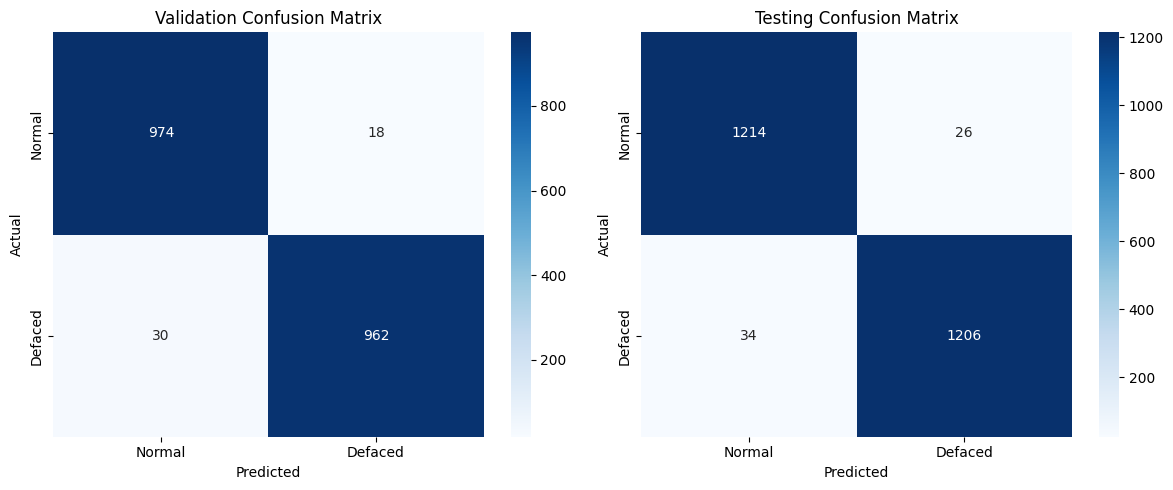

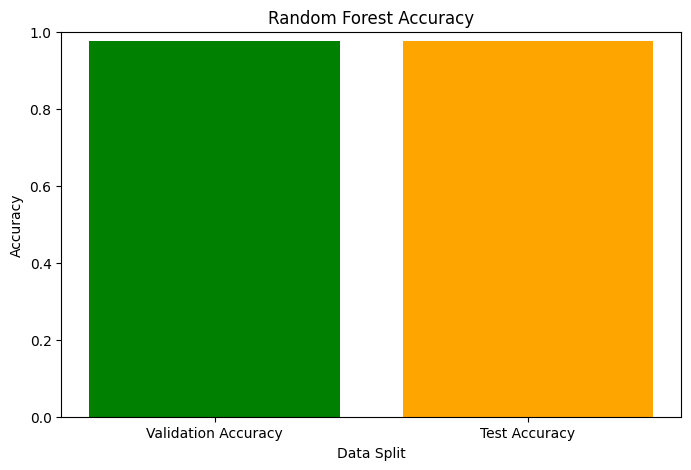

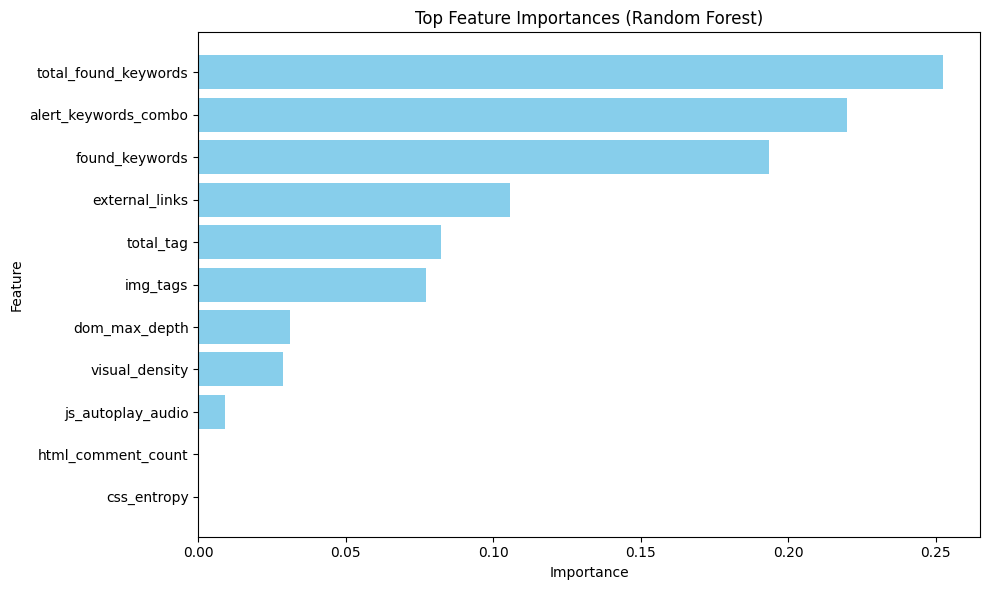

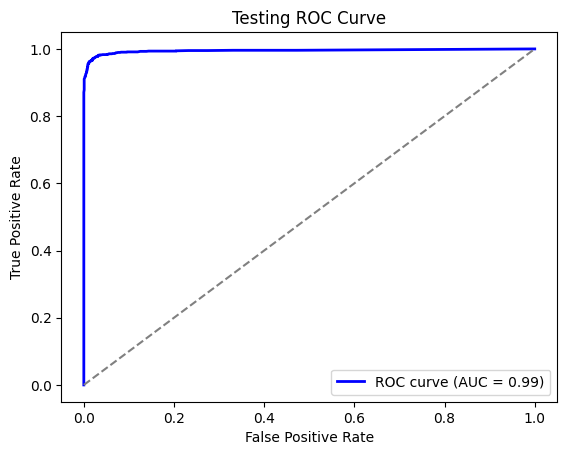

Model Random Forest berhasil disimpan.
False Positive dan False Negative berhasil disimpan.
Hash of X_train: f094496b4a7f9c9c513f061a07288fd7
Hash of y_train: dd7a0749ee54cf69d3e686dc679165ab

=== Resource Usage & Performance Log ===


,Model,Training Time (s),Inference Time (s),CPU Usage (%),RAM Usage (MB),Model Size (MB),Accuracy,Precision,Recall,F1 Score
0,RandomForest,4.89,0.06,3.5,1.27,7.6,0.9758,0.9789,0.9726,0.9757


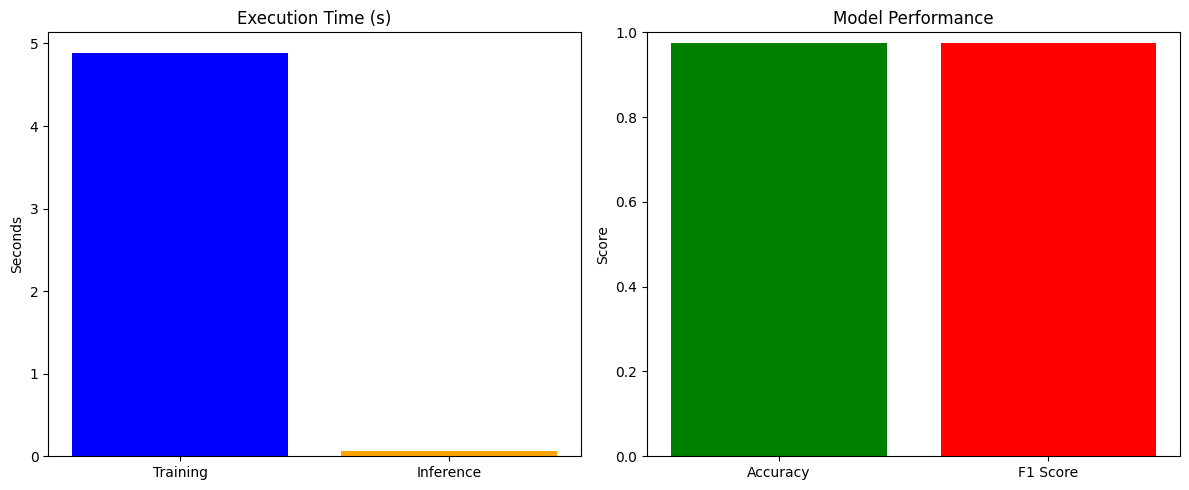

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import psutil
import hashlib
import tracemalloc
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/3. Full Ekstrak Feature Dataset.csv"
df = pd.read_csv(dataset_path)

# Pilih fitur dan label
feature_cols = [
    'total_tag','found_keywords', 'total_found_keywords', 'alert_keywords_combo','external_links',
    'js_autoplay_audio','img_tags','css_entropy','html_comment_count',
    'dom_max_depth','visual_density'
]

X = df[feature_cols]
y = df["label"]
filenames = df["filename"].tolist()

# Split data
X_trainval, X_test, y_trainval, y_test, filenames_trainval, filenames_test = train_test_split(
    X, y, filenames, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X_trainval, y_trainval, filenames_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

# Random Forest dengan Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# Evaluasi
def evaluate_model(model, X, y):
    preds = model.predict(X)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    return accuracy, precision, recall, f1, preds

val_accuracy, val_precision, val_recall, val_f1, val_preds = evaluate_model(rf_best, X_val, y_val)
test_accuracy, test_precision, test_recall, test_f1, test_preds = evaluate_model(rf_best, X_test, y_test)

# Print metrics
print("\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.6f}")
print(f"Precision: {val_precision:.6f}")
print(f"Recall: {val_recall:.6f}")
print(f"F1 Score: {val_f1:.6f}")
print(classification_report(y_val, val_preds))

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.6f}")
print(f"Precision: {test_precision:.6f}")
print(f"Recall: {test_recall:.6f}")
print(f"F1 Score: {test_f1:.6f}")
print(classification_report(y_test, test_preds))

# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, cmap='Blues', fmt='d',
            xticklabels=['Normal', 'Defaced'], yticklabels=['Normal', 'Defaced'], ax=axes[0])
axes[0].set_title("Validation Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, cmap='Blues', fmt='d',
            xticklabels=['Normal', 'Defaced'], yticklabels=['Normal', 'Defaced'], ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# Accuracy Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(["Validation Accuracy", "Test Accuracy"], [val_accuracy, test_accuracy], color=["green", "orange"])
plt.ylim(0, 1)
plt.title("Random Forest Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Data Split")
plt.show()

# Feature Importance
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [feature_cols[i] for i in indices]
top_importances = [importances[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], top_importances[::-1], color="skyblue")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ROC Curve
if hasattr(rf_best, "predict_proba"):
    fpr, tpr, _ = roc_curve(y_test, rf_best.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Testing ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Simpan model
model_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Optimize HTML/random_forest_model.pkl"
joblib.dump(rf_best, model_path)
print("Model Random Forest berhasil disimpan.")

# False Positives & False Negatives
fp_indices = [i for i, (p, t) in enumerate(zip(test_preds, y_test)) if p == 1 and t == 0]
fn_indices = [i for i, (p, t) in enumerate(zip(test_preds, y_test)) if p == 0 and t == 1]
fp_files = [filenames_test[i] for i in fp_indices]
fn_files = [filenames_test[i] for i in fn_indices]

fp_df = pd.DataFrame({'Filename': fp_files})
fn_df = pd.DataFrame({'Filename': fn_files})
fp_df.to_csv('/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Optimize HTML/false_positives.csv', index=False)
fn_df.to_csv('/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Optimize HTML/false_negatives.csv', index=False)
print("False Positive dan False Negative berhasil disimpan.")

# Hash untuk validasi
print("Hash of X_train:", hashlib.md5(np.array(X_train).tobytes()).hexdigest())
print("Hash of y_train:", hashlib.md5(np.array(y_train).tobytes()).hexdigest())

# Logging resource usage dan performa
def log_model_performance(model, X_train, y_train, X_test, y_test, model_name, save_path):
    start_time = time.time()
    process = psutil.Process(os.getpid())
    cpu_before = psutil.cpu_percent(interval=1)

    # Start tracking memory
    tracemalloc.start()

    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    ram_peak_mb = peak / (1024 * 1024)

    model_file = os.path.join(save_path, f"{model_name}_model.pkl")
    joblib.dump(model, model_file)
    model_size = os.path.getsize(model_file) / (1024 * 1024)

    start_infer = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_infer

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    log_dict = {
        "Model": model_name,
        "Training Time (s)": round(training_time, 2),
        "Inference Time (s)": round(inference_time, 2),
        "CPU Usage (%)": cpu_before,
        "RAM Usage (MB)": round(ram_peak_mb, 2),
        "Model Size (MB)": round(model_size, 2),
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    }
    return pd.DataFrame([log_dict])

def plot_resource_and_accuracy(log_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].bar(["Training", "Inference"], [log_df["Training Time (s)"].values[0], log_df["Inference Time (s)"].values[0]], color=["blue", "orange"])
    ax[0].set_title("Execution Time (s)")
    ax[0].set_ylabel("Seconds")

    ax[1].bar(["Accuracy", "F1 Score"], [log_df["Accuracy"].values[0], log_df["F1 Score"].values[0]], color=["green", "red"])
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Model Performance")
    ax[1].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

save_log_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Optimize HTML"
os.makedirs(save_log_path, exist_ok=True)

log_df = log_model_performance(
    model=rf_best,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="RandomForest",
    save_path=save_log_path
)

print("\n=== Resource Usage & Performance Log ===")
display(log_df)

log_df.to_csv(os.path.join(save_log_path, "resource_log.csv"), index=False)
plot_resource_and_accuracy(log_df)


### **RANDOM FOREST DENGAN TEKS DAN FITUR**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Validation Metrics:
Accuracy: 0.9919, Precision: 0.9990, Recall: 0.9849, F1 Score: 0.9919
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       992
           1       1.00      0.98      0.99       992

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Testing Metrics:
Accuracy: 0.9915, Precision: 0.9967, Recall: 0.9863, F1 Score: 0.9915
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1240
           1       1.00      0.99      0.99      1240

    accuracy                           0.99      2480
   macro avg       0.99      0.99      0.99      2480
weighted avg       0.99      0.99      0.99      2480



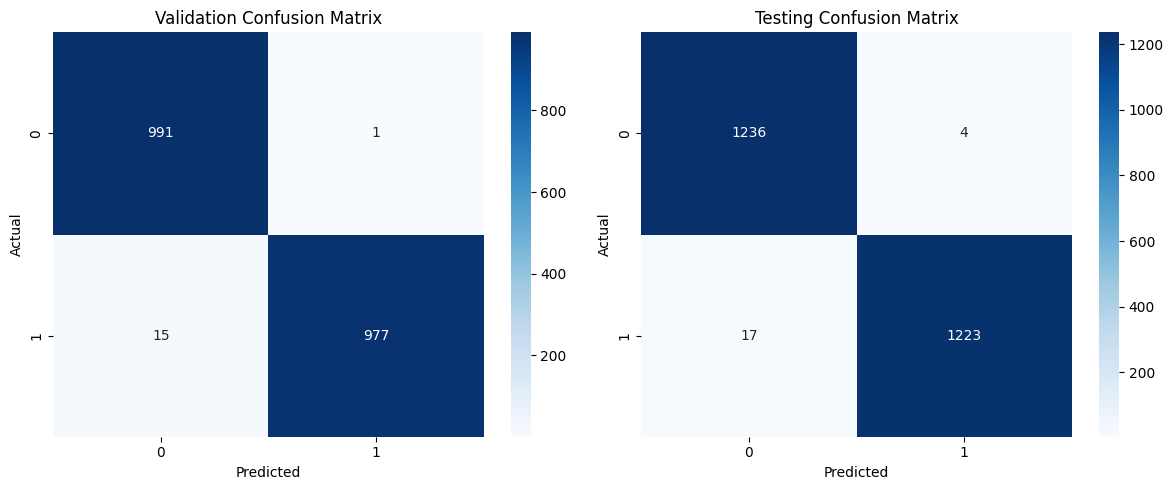

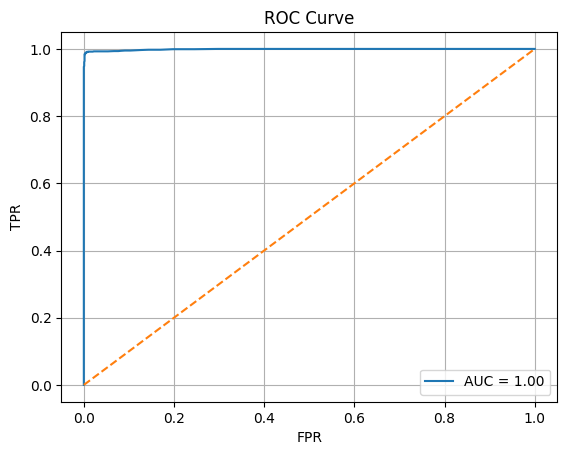

✅ False Positives & Negatives saved.


,Model,Training Time (s),Inference Time (s),CPU Usage (%),RAM Usage (MB),Model Size (MB),Accuracy,Precision,Recall,F1 Score
0,Hybrid_RF_Text+Feature,8.28,0.2,2.5,30.74,3.59,0.9915,0.9967,0.9863,0.9915


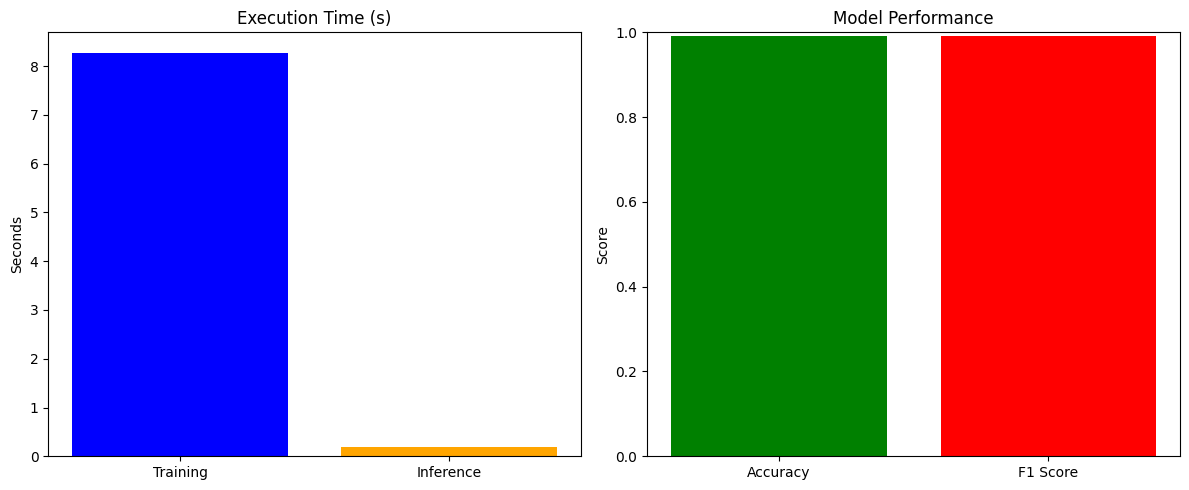

In [3]:
# =============================== [1] Install & Import ===============================
import os, time, joblib, psutil, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from scipy.sparse import hstack, csr_matrix
from google.colab import drive

# =============================== [2] Setup Path & Load ===============================
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/3. Full Ekstrak Feature Dataset.csv"
model_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Optimize HTML/ensemble_model.pkl"
save_log_path = "/content/drive/My Drive/Colab Notebooks/5. Output/1. Random Forest/Optimize HTML"
os.makedirs(save_log_path, exist_ok=True)

df = pd.read_csv(dataset_path).dropna(subset=["flat_tree"])

# =============================== [3] Preprocessing ===============================
text_col = "flat_tree"
label_col = "label"
selected_features = [
    'total_tag','found_keywords', 'total_found_keywords', 'alert_keywords_combo','external_links',
    'js_autoplay_audio','img_tags','css_entropy','html_comment_count',
    'dom_max_depth','visual_density'
]

texts = df[text_col].astype(str).tolist()
labels = df[label_col].astype(int).tolist()
filenames = df["filename"].tolist()
X_feat = df[selected_features].fillna(0).values

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_text = vectorizer.fit_transform(texts)
X_combined = hstack([X_text, csr_matrix(X_feat)])

# =============================== [4] Split ===============================
X_trainval, X_test, y_trainval, y_test, filenames_trainval, filenames_test = train_test_split(
    X_combined, labels, filenames, test_size=0.2, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val, filenames_train, filenames_val = train_test_split(
    X_trainval, y_trainval, filenames_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

# =============================== [5] Train + Evaluate + Log ===============================
process = psutil.Process(os.getpid())
cpu_before = psutil.cpu_percent(interval=1)

# Start tracking memory
tracemalloc.start()

start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

ram_peak_mb = peak / (1024 * 1024)

joblib.dump(rf_model, model_path)
joblib.dump(vectorizer, os.path.join(save_log_path, "vectorizer.pkl"))
model_size = os.path.getsize(model_path) / (1024 * 1024)

# Inference time
start_infer = time.time()
y_pred_test = rf_model.predict(X_test)
inference_time = time.time() - start_infer

# =============================== [6] Evaluation ===============================
def evaluate(name, X, y_true):
    y_pred = rf_model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred))
    return acc, prec, rec, f1, y_pred

val_acc, val_prec, val_rec, val_f1, val_preds = evaluate("Validation", X_val, y_val)
test_acc, test_prec, test_rec, test_f1, test_preds = evaluate("Testing", X_test, y_test)

# =============================== [7] Visualizations ===============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_val, val_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Validation Confusion Matrix"); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Testing Confusion Matrix"); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True); plt.show()

# =============================== [8] Save FP & FN ===============================
fp_indices = [i for i, (p, t) in enumerate(zip(test_preds, y_test)) if p == 1 and t == 0]
fn_indices = [i for i, (p, t) in enumerate(zip(test_preds, y_test)) if p == 0 and t == 1]
fp_files = [filenames_test[i] for i in fp_indices]
fn_files = [filenames_test[i] for i in fn_indices]

pd.DataFrame({'filename': fp_files}).to_csv(f"{save_log_path}/false_positives.csv", index=False)
pd.DataFrame({'filename': fn_files}).to_csv(f"{save_log_path}/false_negatives.csv", index=False)

print("✅ False Positives & Negatives saved.")

# =============================== [9] Log Resource ===============================
log_df = pd.DataFrame([{
    "Model": "Hybrid_RF_Text+Feature",
    "Training Time (s)": round(training_time, 2),
    "Inference Time (s)": round(inference_time, 2),
    "CPU Usage (%)": cpu_before,
    "RAM Usage (MB)": round(ram_peak_mb, 2),
    "Model Size (MB)": round(model_size, 2),
    "Accuracy": round(test_acc, 4),
    "Precision": round(test_prec, 4),
    "Recall": round(test_rec, 4),
    "F1 Score": round(test_f1, 4)
}])

log_df.to_csv(os.path.join(save_log_path, "resource_log.csv"), index=False)

from IPython.display import display
display(log_df)

def plot_resource_and_accuracy(log_df):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].bar(["Training", "Inference"],
              [log_df["Training Time (s)"].values[0], log_df["Inference Time (s)"].values[0]], color=["blue", "orange"])
    ax[0].set_title("Execution Time (s)")
    ax[0].set_ylabel("Seconds")
    ax[1].bar(["Accuracy", "F1 Score"],
              [log_df["Accuracy"].values[0], log_df["F1 Score"].values[0]], color=["green", "red"])
    ax[1].set_ylim(0, 1)
    ax[1].set_title("Model Performance")
    ax[1].set_ylabel("Score")
    plt.tight_layout(); plt.show()

plot_resource_and_accuracy(log_df)
